In [29]:
#------------------------------------------------------------
# Import necessary libraries
#------------------------------------------------------------
from tensorflow.keras.layers import Input, MaxPooling2D, concatenate, Conv2D, UpSampling2D, SpatialDropout2D, BatchNormalization, Activation
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from google.cloud import storage
import numpy as np
import os
import tensorflow
import csv
import time
import tarfile
import glob
from IPython.display import Image, display, clear_output
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, show


In [12]:
#------------------------------------------------------------
# Run to generate credentials - paste the block of code from
# "credentials for BE 547 lab" into this section
#------------------------------------------------------------


In [13]:
#------------------------------------------------------------
# Download the data
#------------------------------------------------------------
client = storage.Client.from_service_account_json("auth.json")
bucket = client.get_bucket("pennclassdata")
blob = bucket.blob("class_data.tar")
blob.download_to_filename("class_data.tar")
# Untar it
file = tarfile.open('class_data.tar')
file.extractall('data')
file.close()
# Download the weights
blob = bucket.blob("liver_run_2_liver_weights.135-0.03-0.84.h5")
blob.download_to_filename("liver_run_2_liver_weights.135-0.03-0.84.h5")
blob = bucket.blob("spleen_run_2_spleen_model.108-0.09-0.89.h5")
blob.download_to_filename("spleen_run_2_spleen_model.108-0.09-0.89.h5")
print("Download complete")


Download complete


In [14]:
#------------------------------------------------------------
# Load helper functions
#------------------------------------------------------------
smooth = 1
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = BatchNormalization(name=prefix + "_bn")(conv)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv

def get_simple_unet(input_shape):
    img_input = Input((input_shape + (1,)))
    conv1 = conv_block_simple(img_input, 32, "conv1_1")
    conv1 = conv_block_simple(conv1, 32, "conv1_2")
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), padding="same", name="pool1")(conv1)

    conv2 = conv_block_simple(pool1, 64, "conv2_1")
    conv2 = conv_block_simple(conv2, 64, "conv2_2")
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), padding="same", name="pool2")(conv2)

    conv3 = conv_block_simple(pool2, 128, "conv3_1")
    conv3 = conv_block_simple(conv3, 128, "conv3_2")
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), padding="same", name="pool3")(conv3)

    conv4 = conv_block_simple(pool3, 256, "conv4_1")
    conv4 = conv_block_simple(conv4, 256, "conv4_2")
    conv4 = conv_block_simple(conv4, 256, "conv4_3")

    up5 = concatenate([UpSampling2D()(conv4), conv3], axis=3)
    conv5 = conv_block_simple(up5, 128, "conv5_1")
    conv5 = conv_block_simple(conv5, 128, "conv5_2")

    up6 = concatenate([UpSampling2D()(conv5), conv2], axis=3)
    conv6 = conv_block_simple(up6, 64, "conv6_1")
    conv6 = conv_block_simple(conv6, 64, "conv6_2")

    up7 = concatenate([UpSampling2D()(conv6), conv1], axis=3)
    conv7 = conv_block_simple(up7, 32, "conv7_1")
    conv7 = conv_block_simple(conv7, 32, "conv7_2")

    conv7 = SpatialDropout2D(0.2)(conv7)

    prediction = Conv2D(1, (1, 1), activation="sigmoid", name="prediction")(conv7)
    model = Model(img_input, prediction)
    return model

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
def getBGRWithOverlay(image, mask, alpha=0.5, color=(0,255,0)):
    overlay = image.copy()
    output = image.copy()
    overlay[:,:,0][mask!=0] = color[0]
    overlay[:,:,1][mask!=0] = color[1]
    overlay[:,:,2][mask!=0] = color[2]
    cv2.addWeighted(overlay, alpha, output, 1-alpha, 0, output)
    return output
def getGrayWithOverlay(image, mask, alpha=0.5, color=(0,255,0)):
    image = grayToBGR(image)
    return getBGRWithOverlay(image, mask, alpha=alpha, color=color)

def grayToBGR(gray):
    grayDims = gray.shape
    grayBGR = np.zeros((grayDims[0], grayDims[1], 3), np.uint8)
    grayBGR[:,:,0] = gray
    grayBGR[:,:,1] = gray
    grayBGR[:,:,2] = gray
    return grayBGR

In [15]:
#------------------------------------------------------------
# Load testing set
#------------------------------------------------------------
imgDirPath = "data/test/image/dummy_class"
imgFilePathList = glob.glob(os.path.join(imgDirPath, "*.png"))
imgFilePathList = sorted(imgFilePathList)

print("Found %d files to test" % (len(imgFilePathList)))

Found 807 files to test


In [16]:
#------------------------------------------------------------
# Load weights
#------------------------------------------------------------
import tensorflow

liverWeightsFilePath = "liver_run_2_liver_weights.135-0.03-0.84.h5"
modelLiver = get_simple_unet((256,256))
modelLiver.load_weights(liverWeightsFilePath)

spleenWeightsFilePath = "spleen_run_2_spleen_model.108-0.09-0.89.h5"
modelSpleen = get_simple_unet((256,256))
modelSpleen.load_weights(spleenWeightsFilePath)

print("Finished loading weights")

Finished loading weights


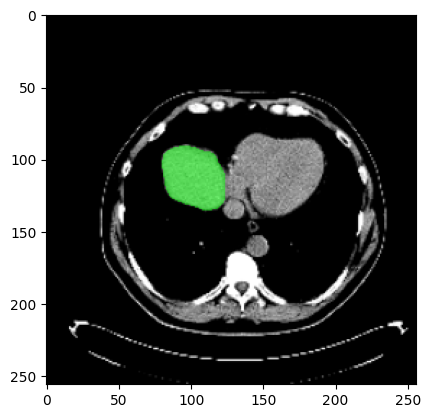

data/test/image/dummy_class/1147897494458_513455554189_axial_0098.png


In [42]:
#------------------------------------------------------------
# Show example segmentations
#------------------------------------------------------------
lastSliceToShow = 100
print(len(imgFilePathList))

for index in range(60, min(lastSliceToShow, len(imgFilePathList)),2):
    imgFilePath = imgFilePathList[index]
    img = cv2.imread(imgFilePath,0)
    img = cv2.resize(img, (256,256))
    imgOrig = img.copy()
    img = img[np.newaxis, :, :, np.newaxis]
    resultLiver = modelLiver.predict(img,verbose=0)[0,:,:,0]
    maskLiver = resultLiver > 0.5
    resultSpleen = modelSpleen.predict(img,verbose=0)[0,:,:,0]
    maskSpleen = resultSpleen > 0.5
    overlay = getGrayWithOverlay(imgOrig, maskLiver, alpha=0.5, color=(0,255,0))
    overlay = getBGRWithOverlay(overlay, maskSpleen, alpha=0.5, color=(255,0,0))
    imshow(overlay)
    show()
    print(imgFilePath)
    time.sleep(1)
    clear_output(wait=True)